<a href="https://colab.research.google.com/github/javmencia/RelativeBelief/blob/BiasCalculations/RegressionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.special import gammaln
from scipy import stats
import time
import math

In [6]:
import pymc as pm
import numpy as np

def normal_logp(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - pm.math.log(sigma) - 0.5 * pm.math.log(2 * np.pi)

# Define parameters

# For x
mu_prior_mean = 0
mu_prior_sigma = 1


n = 50
p = 2
mu_0 = 0

# Design matrix X
X = np.random.normal(size=(n, p))

# For beta
beta_mu_0 = np.zeros(p)
beta_cov_0 = np.eye(p)

# For sigma
sigma_mu_0 = 1
sigma_sigma_0 = 1

y_0 = np.ones(n)

with pm.Model() as m:

    # Priors
    mu_ = pm.Normal('mu_', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=1)
    x_ = pm.Normal('x_', mu=mu_0, sigma=1, shape=n)

    beta = pm.MvNormal("beta", mu=beta_mu_0, cov=beta_cov_0, shape=p)
    sigma = pm.TruncatedNormal("sigma", mu=sigma_mu_0, sigma=sigma_sigma_0, lower=0)

    # Likelihood
    y = pm.Normal('y', mu=pm.math.dot(X, beta), sigma=sigma)

    # Prior predictive densities
    prior_beta = pm.Deterministic("prior_beta", pm.logp(pm.MvNormal.dist(mu=beta_mu_0, cov=beta_cov_0, shape=p), beta))
    prior_sigma = pm.Deterministic("prior_sigma", pm.logp(pm.TruncatedNormal.dist(mu=sigma_mu_0, sigma=sigma_sigma_0, lower=0), sigma))
    prior_y = pm.Deterministic("prior_y", pm.logp(pm.Normal.dist(mu=pm.math.dot(X, beta_mu_0), sigma=sigma_mu_0), y_0))

    # Posterior predictive densities
    posterior_y = pm.Deterministic("posterior_y", pm.logp(pm.Normal.dist(mu=pm.math.dot(X, beta), sigma=sigma), y_0))

    logBR_prior_pd = pm.Deterministic("logBR_prior_pd", posterior_y - prior_y)

    """
    # prior predictive data density evaluations
    prior_prior_pd = pm.Deterministic("prior_prior_pd", normal_logp(mu_0,0,1))

    posterior_var = 1/(1/mu_prior_sigma**2 + n/1)
    posterior_mean = (mu_prior_mean/mu_prior_sigma**2 + x_.sum()/1)*posterior_var
    posterior_prior_pd = pm.Deterministic("posterior_prior_pd",
                                          normal_logp(mu_0, posterior_mean, posterior_var**0.5))
    logBR_prior_pd = pm.Deterministic("logBR_prior_pd", posterior_prior_pd-prior_prior_pd) # pm.math.exp()

    likelihood_prior_pd = pm.Deterministic("likelihood_prior_pd", normal_logp(x_,mu_0,1).sum())"""

with m:
    idata = pm.sample(draws=1000)

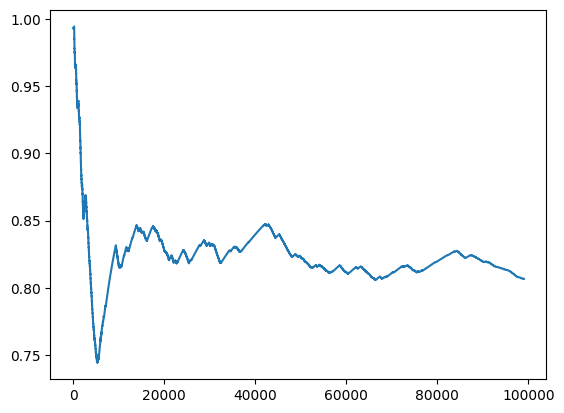

In [7]:
# Calculate the bias against the prior hypothesis
bias_against = idata.posterior["logBR_prior_pd"].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum() / np.arange(1, t+1)

plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')
